<a href="https://colab.research.google.com/github/pareshrchaudhary/pid-optimization/blob/main/pid_evolutionary%26swarm_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(2, 3250)


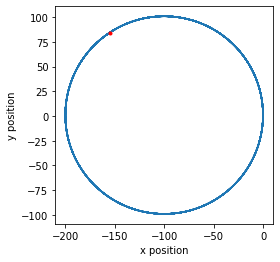

In [ ]:
# pidtraj3 follow a complex trajectory defined by waypoints
# this uses a more complex error function than pidtraj1

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# This cell is the car kinematics...same as in carkin1.ipynb
# outputs:
#    xnew, ynew, thetanew
# inputs:
#    delta - steering angle (radians)
#    s     - speed
#    theta - car heading (radians)
#    x     - x coordinate of car base frame
#    y     - y coordinate of car base frame
#    L     - Length of car
#    dt    - time increment
def carkin(delta, s, theta,x,y,L,dt):
  dx = np.cos(theta)*s*dt
  dy = np.sin(theta)*s*dt
  dtheta = (s/L) * np.tan(delta) * dt
  xnew = x + dx
  ynew = y + dy
  thetanew = theta + dtheta
  thetanew = np.mod(thetanew,2.0*np.pi) # Wrap theta at 2pi
  return([xnew,ynew,thetanew])

rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0

# Test it out
delta = 0.5729 * deg2rad
s = 100.0
theta = 90.0 * deg2rad # car heading in radians
x = 0.0
y = 0.0
L = 1.0
dt = 0.02

Tmax = 65
Trange = np.arange(0,Tmax,dt)
T_xseries = np.zeros(len(Trange))
T_yseries = np.zeros(len(Trange))
thetaseries = np.zeros(len(Trange))
for i in range(len(Trange)):
  [xnew,ynew,thetanew] = carkin(delta,s,theta,x,y,L,dt)
  T_xseries[i] = xnew
  T_yseries[i] = ynew
  thetaseries[i] = thetanew

  x = xnew
  y = ynew
  theta = thetanew

plt.figure(1)
plt.plot(T_xseries,T_yseries)
plt.axis('square')
plt.xlabel('x position')
plt.ylabel('y position')

plt.plot(x,y,'r.')

target = np.array([T_xseries,T_yseries])
print(target.shape)

# plt.figure(2)
# plt.plot(Trange,thetaseries*rad2deg)
# plt.xlabel('Time');
# plt.ylabel('Car heading (degrees)')

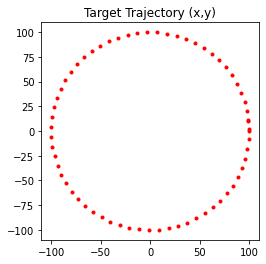

In [ ]:
# Example trajectories
NTRAJSTEPS = 65 # no gap for dt = 0.1
#NTRAJSTEPS = 60 # gap for dt = 0.1
#NTRAJSTEPS = 30 # partial ellipse for dt = 0.1
#NTRAJSTEPS = 10 # partial ellipse for dt = 0.1

dt = 0.1
ttx = np.zeros(NTRAJSTEPS) # target trajectory x
tty = np.zeros(NTRAJSTEPS) # target trajectory y
targtrajtarray = np.arange(0.0,NTRAJSTEPS*dt,dt)

# Straight line: compute positions
#for i in range(len(targtrajtarray)):
#  ttx[i] = 50.0
#  tty[i] = i*(500.0 / (len(targtrajtarray)-1))

#Circle: compute positions
for i in range(len(targtrajtarray)):
  ttx[i] = 100*np.cos(targtrajtarray[i]) # Circle of radius 100
  tty[i] = 100*np.sin(targtrajtarray[i])

# Heart: compute positions
# for i in range(len(targtrajtarray)):
#   ttx[i] = 16*np.sin(targtrajtarray[i])**3
#   tty[i] = 13*np.cos(targtrajtarray[i]) - 5*np.cos(2*targtrajtarray[i]) - 2*np.cos(3*targtrajtarray[i]) - np.cos(4*targtrajtarray[i])


# Oval: compute positions
# for i in range(len(targtrajtarray)):
#  ttx[i] = 150*np.cos(targtrajtarray[i]) # 150 x 75 ellipse
#  tty[i] = 75*np.sin(targtrajtarray[i])

tttheta = np.zeros(len(ttx))
# Compute headings from positions
for i in range(1,len(targtrajtarray)-1): # no heading for first and last position
  prevpos = np.array((ttx[i-1],tty[i-1]))
  nextpos = np.array((ttx[i+1],tty[i+1]))
  heading = nextpos - prevpos
  tttheta[i] = np.arctan2(heading[1],heading[0])

heading = np.array((ttx[1],tty[1])) - np.array((ttx[0],tty[0]))
tttheta[0] = np.arctan2(heading[1],heading[0])

heading = np.array((ttx[len(targtrajtarray)-1],tty[len(targtrajtarray)-1])) - np.array((ttx[len(targtrajtarray)-2],tty[len(targtrajtarray)-2]))
tttheta[len(targtrajtarray)-1] = np.arctan2(heading[1],heading[0])


plt.figure()
plt.plot(ttx,tty,'r.')
plt.axis('square');
plt.title('Target Trajectory (x,y)')

rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0

In [ ]:
def findnearest(ttx,tty,carx,cary,lookahead):
  dist = np.sqrt((ttx[0:-lookahead-1]-carx)**2 + (tty[0:-lookahead-1]-cary)**2)
  mindist = np.amin(dist)
  minindex = np.where(dist == mindist)
  mi = minindex[0][0]
  return([mi, mindist]) # index of minimum distance, actual distance

In [ ]:
# Same function as findnearest, but just search in a limited window around
#  a starting index
def findnearestinindow(ttx,tty,carx,cary,ind,windowsize):
  windlow = max(ind-windowsize,0)
  windhi = min(ind+windowsize,len(ttx)-1)
  dist = np.sqrt((ttx[windlow:windhi]-carx)**2 + (tty[windlow:windhi]-cary)**2)
  mindist = np.amin(dist)
  minindex = np.where(dist == mindist)
  mi = minindex[0][0]
  return([mi, mindist]) # index of minimum distance, actual distance

In [ ]:
def action(Kp, Kd, error_1 , error_2):

  correction = -Kp * error_1 + Kd*((error_2-error_1 )/dt)

  return correction

In [ ]:
def reward(NDRIVESTEPS, error_performance):

  target = np.zeros(NDRIVESTEPS)
  test = error_performance

  return np.sqrt(np.sum((target - test) ** 2))

In [ ]:
def fit(parameters, visualize = 0):
  """Implements PID error correction on

  Parameters: [Kp: Proportional gain, Kd: Derivative gain].
  vidualize: if 1 then returns target vs actual trajectory and crosstrack error.

  Returns: Fitness of the controller"""

  Kp = parameters[0]
  Kd = parameters[1]
  # for circle
  NDRIVESTEPS = 400
  lookahead = 2
  dt = 0.02

  maxsteerdeg = 25.0

  drivetrajtarray = np.arange(0.0,NDRIVESTEPS*dt,dt)
  xseries = np.zeros(NDRIVESTEPS)
  yseries = np.zeros(NDRIVESTEPS)
  thetaseries = np.zeros(NDRIVESTEPS)
  targetseries = np.full(NDRIVESTEPS,0+0*1j)
  crosserrseries = np.zeros(NDRIVESTEPS)
  deltaseries = np.zeros(NDRIVESTEPS)
  sseries = np.zeros(NDRIVESTEPS)
  T_xseries = np.zeros(NDRIVESTEPS)
  T_yseries = np.zeros(NDRIVESTEPS)

  # Initial values
  #xseries[0] = 95.0 # works
  #yseries[0] = 0.0
  #xseries[0] = 55.0
  #yseries[0] = 0.0
  xseries[0] = 100.0
  yseries[0] = 0.0
  thetaseries[0] = 90.0* deg2rad
  deltaseries[0] = 0.0
  sseries[0] = 150
  targetseries[0] = np.cos(tttheta[0])+np.sin(tttheta[0])*1j

  # Constants
  L = 1.0 # big oscillations in straight case...circle: in and out

  mi = 0
  mindist =0.0
  for i in range(1,NDRIVESTEPS):
    [xseries[i],yseries[i],thetaseries[i]] = carkin(deltaseries[i-1],sseries[i-1],thetaseries[i-1],xseries[i-1],yseries[i-1],L,dt)
    [mi,mindist] = findnearest(ttx,tty,xseries[i],yseries[i],lookahead)
    nearesttrajvec = np.array((ttx[mi]-xseries[i],tty[mi]-yseries[i]))
    carLeftvec = np.array(((np.cos((np.pi/2.0) + thetaseries[i])),(np.sin((np.pi/2.0) + thetaseries[i]))))
    crosserrseries[i] = -np.dot(nearesttrajvec,carLeftvec)

    #delta = -Kp * crosserrseries[i] + Kd*((crosserrseries[i-1]-crosserrseries[i])/dt)
    delta = action(Kp, Kd, crosserrseries[i], crosserrseries[i-1])

    delta = max(delta,-maxsteerdeg*deg2rad) # 10 deg max steering
    delta = min(delta,maxsteerdeg*deg2rad) # 10 deg max steering
    deltaseries[i] = delta
    sseries[i] = sseries[i-1]

  fitness = reward(NDRIVESTEPS, crosserrseries)

  if (visualize == 1):
    plt.figure()
    plt.plot(ttx,tty,'r.')
    plt.plot(xseries[0:-lookahead-1],yseries[0:-lookahead-1])
    plt.axis('square');
    plt.title('Target Trajectory (x,y) vs actual' + ' with ' + 'Fitness = '+ str(fitness) );
    plt.text(-50, 0, 'Kp='+str(Kp)+'Kd='+str(Kd))

    plt.figure()
    plt.plot(drivetrajtarray[0:-lookahead-1],crosserrseries[0:-lookahead-1])
    plt.title('Cross-track error vs t')

  return fitness

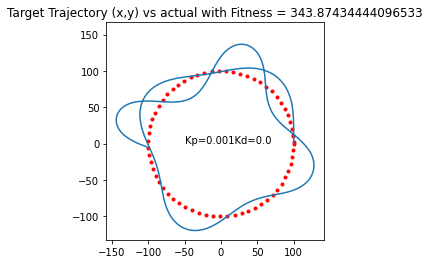

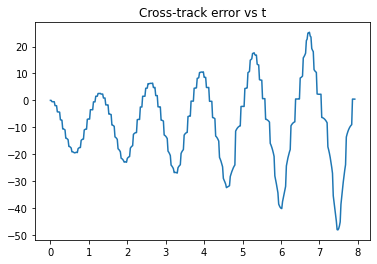

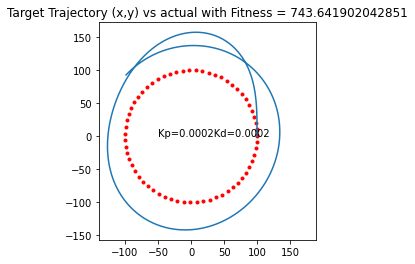

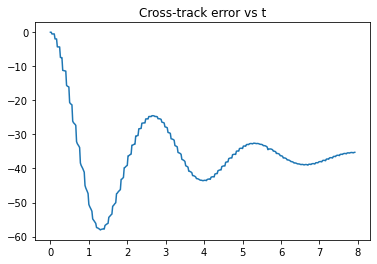

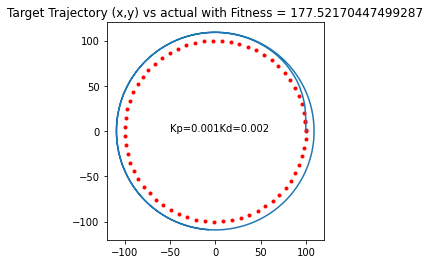

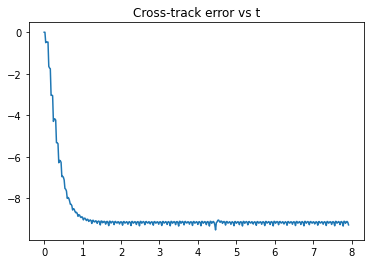

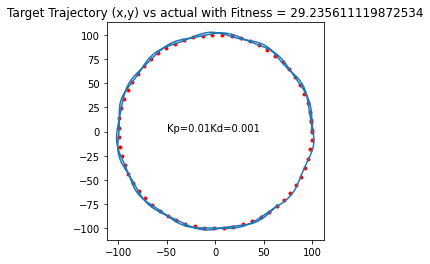

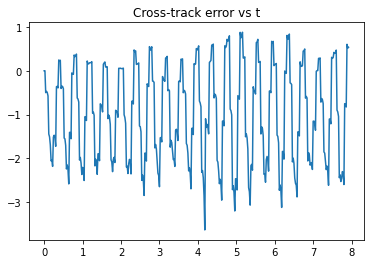

In [ ]:
# big oscillations in straight case...circle: in and out
Kp = 0.001
Kd = 0.0
t1 = fit([Kp, Kd], visualize= 1)

# Circles outside track
Kp = 0.0002
Kd = 0.0002
t2 = fit([Kp, Kd], visualize= 1)

# Decently follows circular track, slowly leaving it
Kp = 0.001
Kd = 0.002
t3 = fit([Kp, Kd], visualize= 1)

# Follows track well
Kp= 0.01
Kd = 0.001
t4 = fit([Kp, Kd], visualize= 1)

#Reinforcement

###1) Random Search Optimization

source: https://kenndanielso.github.io/mlrefined/blog_posts/5_Zero_order_methods/5_4_Random_search.html

In [ ]:
import random
import numpy as np


def RSO(function, dimensions, lower_boundary,
                     upper_boundary, max_iter, maximize=False):
    best_solution = np.array([float()] * dimensions)

    for i in range(dimensions):
        best_solution[i] = random.uniform(lower_boundary[i], upper_boundary[i])

    for _ in range(max_iter):

        solution1 = function(best_solution)

        new_solution = [lower_boundary[d] + random.random()*(upper_boundary[d]-lower_boundary[d]) for d in range(dimensions)]

        if np.greater_equal(new_solution,
               lower_boundary).all() and np.less_equal(new_solution
                         ,upper_boundary).all():
            solution2 = function(new_solution)
        elif maximize:
            solution2 = -100000.0
        else:
            solution2 = 100000.0

        if solution2 > solution1 and maximize:
            best_solution = new_solution
        elif solution2 < solution1 and not maximize:
            best_solution = new_solution

    best_fitness = function(best_solution)

    return best_fitness, best_solution

9.474754101257558 [0.02186371554782631, 0.0049271760723805695]


9.474754101257558

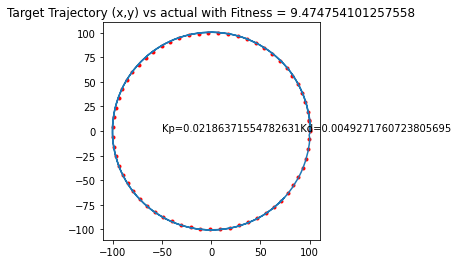

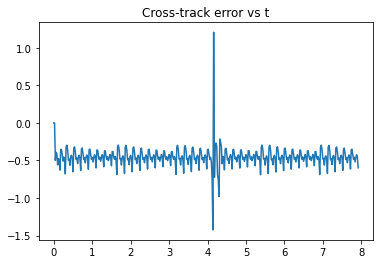

In [ ]:
a, b = RSO(fit, dimensions = 2, lower_boundary = [0.000001, 0.000001], upper_boundary = [0.1, 0.1] , max_iter= 500, maximize=False)
print(a,b)
fit(b, visualize = 1)

10.211780106129309 [0.01994008427345698, 0.004234174617962289]


10.211780106129309

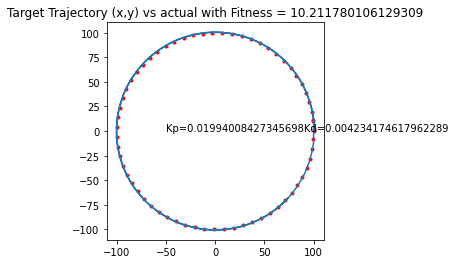

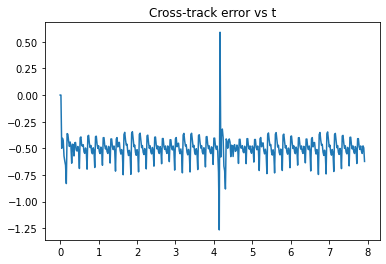

In [ ]:
a, b = RSO(fit, dimensions = 2, lower_boundary = [0.000001, 0.000001], upper_boundary = [0.1, 0.1] , max_iter= 1000, maximize=False)
print(a,b)
fit(b, visualize = 1)

###2) Particle Swarm Optimization

source: https://en.wikipedia.org/wiki/Particle_swarm_optimization

In [ ]:
from numpy.core.fromnumeric import clip

def PSO(fitness_function, iteration, population, inertia, c1, c2):
  """Implements Particle Swarm Optimization

  fitness_function: Evaluates PID performance on objective function
  iteration: Number of iterations
  population: Total population
  inertia: inertia of particles
  c1: Acceleration coefficient 1
  c2: Acceleration coefficient 2

  Returns: The best agent out of all the population"""

  Kp_lower = 0.0000001
  Kd_lower = 0.0000001
  Kp_upper = 0.1
  Kd_upper = 0.1

  # p = np.random.uniform(Kp_lower, high=Kp_upper, size=(population,2))
  # v = np.random.uniform(Kd_lower, high=Kd_upper, size=(population,2))
  mean = (Kp_lower + Kp_upper)/2
  sd = 0.05
  p = np.random.normal(mean, sd, size=(population,2))
  # v = np.random.normal(mean, sd, size=(population,2))
  v = np.zeros((population,2))

  p_out = np.zeros(len(p))
  for i in range(0,len(p)):
    p_out[i] = fitness_function(p[i])

  learning = []
  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
  print('Initialization: Population ->', population, 'Iterations ->', iteration, 'Inertia ->', inertia, 'C1 ->', c1, 'C2 ->', c2 )
  print('Population  = ', p)
  print('Population Fitness = ', p_out)
  # print('Population Velocity = ', v)

  p_best = np.copy(p)                                                         #best of particle population
  p_best_out =  np.copy(p_out)                                                #best fitness of particle population

  for iter in range(0, iteration):
    print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    print('Generation = ', iter)
    g_best  = p_best[np.argmin(p_best_out)]                                   #best out of particle population
    g_best_out = p_best_out[np.argmin(p_best_out)]                            #fitness value of best out of the particle population
    # r1 = np.random.uniform(low=Kp_lower, high=Kp_upper, size=(len(p), 2))     #random sample 1
    # r2 = np.random.uniform(low=Kp_lower, high=Kp_upper, size=(len(p), 2))     #random sample 2
    r1 = np.random.normal(mean, sd, size=(len(p), 2))     #random sample 1
    r2 = np.random.normal(mean, sd, size=(len(p), 2))     #random sample 2
    v = (inertia * v) + (c1 * r1 * (p_best - p)) + (c2 * r2 * (g_best - p))   #velocity of particles
    # print('v = ', v)
    p = p + v
    #bounding X_new
    p = np.clip(p, Kp_lower, Kp_upper)
    p = np.clip(p, Kd_lower, Kd_upper)
    #Evaluate & Update fitness of population
    for i in range(0, len(p)):
      p_out[i] = fit(p[i])
      if p_out[i] < p_best_out[i]:
        p_best[i] = p[i]
        p_best_out[i] = p_out[i]
        # print('Particle best = ', i, ' & Score = ', p_best_out[i])

    learning.append(p_best_out[np.argmin(p_best_out)])                        #learning metric

    print('Global best = ', g_best, ' & Score = ', g_best_out)
    print("Best Agent = " + str(np.argmin(p_best_out)) + " & Score = ", p_best_out[np.argmin(p_best_out)])


  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
  print('Training done')

  plt.figure()
  plt.plot(range(1,iteration+1),learning)
  plt.margins(y = 0.1);
  # plt.ylim(0, 100)
  plt.axis('square');
  plt.title('Iteration vs Error after' + ' ' + str(iteration) + ' iterations & with ' + str(len(p)) + ' population'  );

  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
  print('Best and Worst of the Population')

  best_sample = p_best[np.argmin(p_best_out)]
  best_perform = p_best_out[np.argmin(p_best_out)]
  print("Best Agent = " + str(np.argmin(p_best_out)) + " & Score = ", p_best_out[np.argmin(p_best_out)])
  fitness_function(best_sample, visualize = 1 )

  worst_sample = p_best[np.argmax(p_best_out)]
  worst_perform = p_best_out[np.argmax(p_best_out)]
  print("Worst Agent = " + str(np.argmax(p_best_out)) + " & Score = ", p_best_out[np.argmax(p_best_out)])
  fitness_function(worst_sample, visualize = 1 )

  return best_sample

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Initialization: Population -> 100 Iterations -> 10 Inertia -> 0.6 C1 -> 0.1 C2 -> 0.2
Population  =  [[ 8.60619807e-02  8.87171416e-02]
 [ 2.01893535e-02  2.18805229e-02]
 [ 5.24165601e-02  7.46507083e-02]
 [-7.81327127e-03  7.06142155e-02]
 [ 7.29273311e-02  1.16809072e-02]
 [ 2.73348153e-02  6.67840359e-02]
 [ 7.30675327e-02  6.10824679e-05]
 [-2.35334243e-02 -5.03716693e-02]
 [-4.07021472e-03  1.56658190e-01]
 [ 4.03615810e-02  1.13786547e-02]
 [ 2.97148243e-02  1.51147242e-01]
 [ 4.30274191e-02  8.69100431e-02]
 [ 4.04549740e-02  2.26327504e-02]
 [ 8.87971305e-02  3.55379531e-02]
 [ 1.29355188e-01  8.37848812e-02]
 [ 5.60536724e-02  8.29696096e-02]
 [ 1.23575423e-01  5.30021945e-02]
 [ 1.88645823e-02  8.68355508e-03]
 [ 1.00019092e-01  6.00722992e-02]
 [ 3.42959512e-02  3.20523357e-02]
 [ 8.38724155e-02  1.19948272e-01]
 [ 7.44021605e-02 -1.87431981e-02]
 [ 7.03411212e-02  5.91633503e-02]
 [ 5.76545094e-02 

array([0.01504648, 0.00200021])

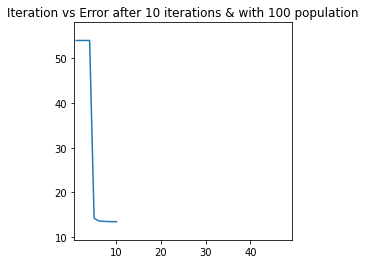

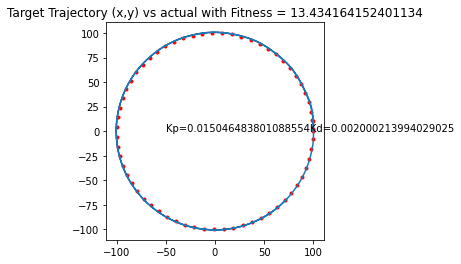

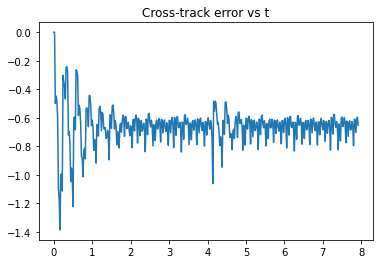

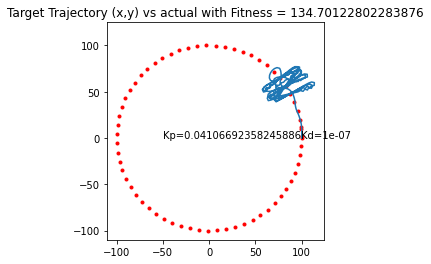

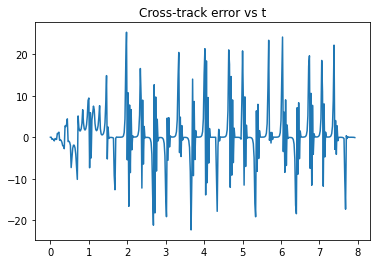

In [ ]:
PSO(fit, iteration = 10, population = 100, inertia = 0.6, c1 = 0.1, c2 = 0.2)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Initialization: Population -> 200 Iterations -> 5 Inertia -> 0.6 C1 -> 0.1 C2 -> 0.6
Population  =  [[ 1.39806071e-01  1.57536319e-02]
 [ 8.94294590e-02  3.29760458e-02]
 [-2.79968997e-02 -7.73089777e-02]
 [ 1.71817613e-02 -5.41918866e-02]
 [ 1.09667966e-04  1.20250532e-01]
 [ 2.17819121e-02 -1.71309511e-02]
 [ 2.55887208e-02  6.19645363e-02]
 [ 6.24743218e-02  4.04457903e-02]
 [ 7.34116486e-02 -5.16417690e-02]
 [ 5.51628870e-02 -9.32997410e-03]
 [ 8.54782110e-02  6.02080634e-02]
 [ 2.29247340e-02  3.24663095e-02]
 [ 1.10303609e-01  8.04681760e-02]
 [ 3.94623498e-02  1.15850231e-01]
 [ 7.94142733e-02 -1.32980299e-02]
 [-2.46036716e-03 -4.05898993e-02]
 [ 8.95060156e-02  2.84957981e-02]
 [-2.03594244e-02  6.83218871e-02]
 [-2.08282716e-02  4.79955320e-02]
 [ 7.33678374e-02  7.19215473e-02]
 [ 1.19469526e-03  1.04014977e-01]
 [ 1.27101509e-02  6.48839256e-02]
 [ 2.16714987e-02 -3.97447376e-03]
 [ 5.12351389e-02  

array([0.02301163, 0.00287722])

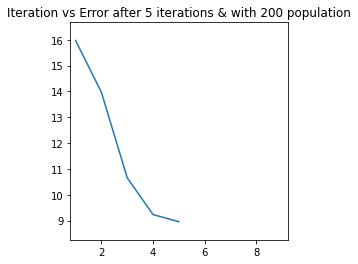

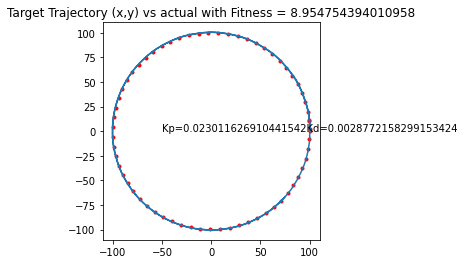

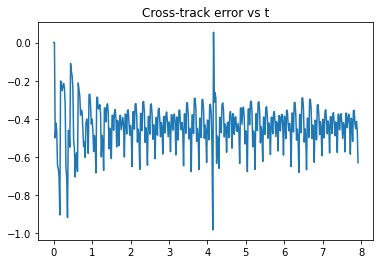

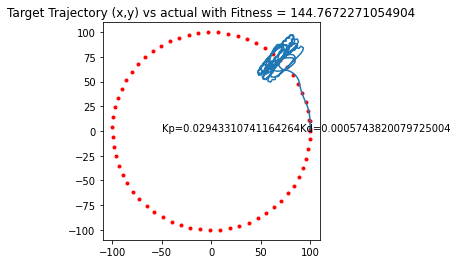

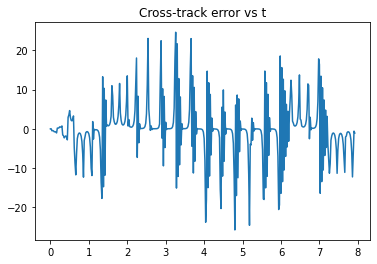

In [ ]:
PSO(fit, iteration = 5, population = 200, inertia = 0.6, c1 = 0.1, c2 = 0.6)

###3) Teaching Learning-Based Optimization

source: https://sites.google.com/site/tlborao/

In [ ]:
from numpy.core.fromnumeric import clip

def TLBO(fitness_function, iteration, population):
  """Implements Teaching Learning-Based Optimization

  fitness_function: Evaluates PID performance on objective function
  iteration: Number of iterations
  population: Number of Population

  Returns: The best agent out of all the population"""

  Kp_lower = 0.0000001
  Kd_lower = 0.0000001
  Kp_upper = 0.1
  Kd_upper = 0.1

  mean = (Kp_lower + Kp_upper)/2
  sd = 0.05
  p = np.random.normal(mean, sd, size=(population,2))

  p_out = np.zeros(len(p))
  for i in range(0,len(p)):
    p_out[i] = fitness_function(p[i])
  print(p)
  print(p_out)

  learning = []
  for iter in range(0, iteration):
    print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    print('Generation = ', iter)
    for i in range(0, len(p)):
      #teaching
      # r = np.random.uniform(low=Kp_lower, high=Kp_upper, size=(2,))     #random sample
      r = np.random.normal(mean, sd, size=(2,))
      Tf = np.random.randint(low=1, high=3, size=(1,))                  #teaching factor
      p_best = p[np.argmin(p_out)]                                      #best out of population
      p_mean = np.mean(p, axis=0)                                       #mean of all population
      # print('p_best =', p_best)
      # print('p_mean =', p_mean)
      X_new = p[i] + r*(p_best - Tf*p_mean)                             #new features for sample
      #bounding X_new
      X_new[0] = np.clip(X_new[0], Kp_lower, Kp_upper)
      X_new[1] = np.clip(X_new[1], Kd_lower, Kd_upper)
      #Checking if X_new is better than previous solution
      fitness = fitness_function(X_new)
      if  fitness < p_out[i]:                                           #checking fitness
        p[i]  = X_new
        p_out[i] = fitness
        # print('TEACHING')
        # print('X_new = ', X_new)
        # print('X_new fitness = ', fitness)
        # print('*PARAMETERS UPDATED')

      #Learning
      p_rand = np.random.randint(low=0, high=len(p), size=(1,))         #random sample out of population
      # r = np.random.uniform(low=Kp_lower, high=Kp_upper, size=(2,))     #random sample
      r = np.random.normal(mean, sd, size=(2,))
      # print('p_rand = ', p_rand)
      if p_out[i] < p_out[p_rand]:
        # print('p_out[i] < p_out[p_rand]')
        X_new = p[i] + r*(p[i] - p[p_rand])
        X_new = np.squeeze(X_new)
        # print('X_new = ', X_new)
      else :
        # print('p_out[i] > p_out[p_rand]')
        X_new = p[i] - r*(p[i] - p[p_rand])
        X_new = np.squeeze(X_new)
        # print('X_new = ', X_new)
      #bounding X_new
      X_new[0] = np.clip(X_new[0], Kp_lower, Kp_upper)
      X_new[1] = np.clip(X_new[1], Kd_lower, Kd_upper)
      #Checking if X_new is better than previous solution
      fitness = fitness_function(X_new)                                 #checking fitness
      if  fitness < p_out[i]:
        p[i]  = X_new
        p_out[i] = fitness
        # print('LEARNING')
        # print('X_new = ', X_new)
        # print('X_new fitness = ', fitness)
        # print('*PARAMETERS UPDATED')

    learning.append(p_out[np.argmin(p_out)])                            #learning metric
    print("Best Agent = " + str(np.argmin(p_out)) + " & Score = ", p_out[np.argmin(p_out)])


  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
  print('Training done')

  plt.figure()
  plt.plot(range(1,iteration+1),learning)
  plt.margins(y = 0.1);
  # plt.ylim(0, 100)
  plt.axis('square');
  plt.title('Iteration vs Error after' + ' ' + str(iteration) + ' iterations & with ' + str(len(p)) + ' population'  );

  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
  print('Best and Worst of the Population')

  best_sample = p[np.argmin(p_out)]
  best_perform = p_out[np.argmin(p_out)]
  print("Best Agent = " + str(np.argmin(p_out)) + " & Score = ", p_out[np.argmin(p_out)])
  fitness_function(best_sample, visualize = 1 )

  worst_sample = p[np.argmax(p_out)]
  worst_perform = p_out[np.argmax(p_out)]
  print("Worst Agent = " + str(np.argmax(p_out)) + " & Score = ", p_out[np.argmax(p_out)])
  fitness_function(worst_sample, visualize = 1 )

  return best_sample

[[ 0.06481718  0.14310365]
 [ 0.00193533  0.03347285]
 [ 0.1141713   0.07341469]
 [ 0.01859976  0.07188058]
 [ 0.03101626  0.104922  ]
 [ 0.0457527  -0.01505555]
 [ 0.11434415 -0.03906565]
 [ 0.05577075  0.04249544]
 [ 0.06800254  0.00348397]
 [ 0.04285509  0.04179031]
 [ 0.14037748  0.02905789]
 [ 0.02959266  0.0391541 ]
 [ 0.09826884  0.10201879]
 [ 0.11527735  0.05930654]
 [ 0.05442812  0.05528043]
 [ 0.01787673  0.01610418]
 [ 0.03809874  0.1305586 ]
 [ 0.03024965  0.03738066]
 [ 0.00529027  0.08788433]
 [ 0.05223048  0.0224646 ]
 [ 0.07142046 -0.00485604]
 [ 0.09015538 -0.02475483]
 [ 0.03410085  0.09197665]
 [ 0.10602671  0.01512104]
 [ 0.00101044  0.05312951]
 [ 0.10600313  0.08607363]
 [ 0.08029267 -0.01415966]
 [ 0.08683314 -0.04437732]
 [ 0.00443133  0.10991755]
 [ 0.00943535  0.08224838]
 [ 0.00479311  0.12361629]
 [ 0.0473018  -0.05469369]
 [ 0.07626735  0.17662495]
 [ 0.01550444  0.02937384]
 [ 0.0927628   0.01887558]
 [ 0.10715106  0.07368719]
 [ 0.09867006  0.03560661]
 

array([0.02237872, 0.00362521])

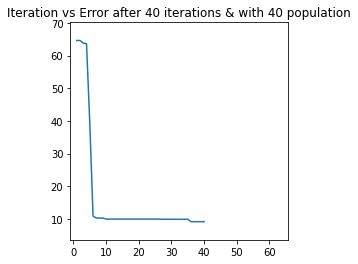

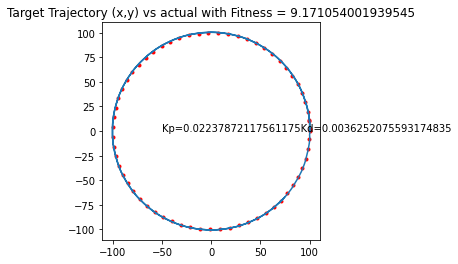

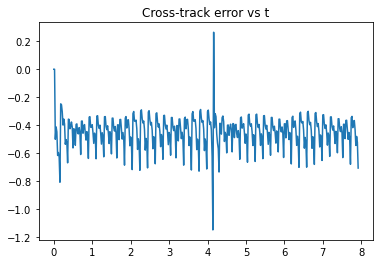

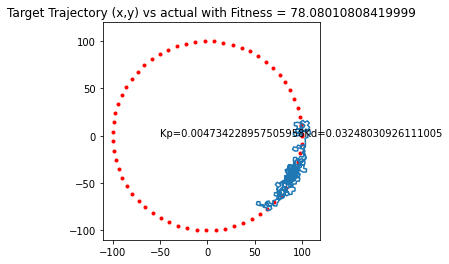

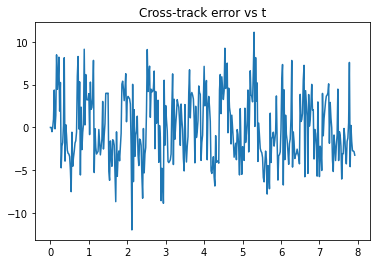

In [ ]:
TLBO(fit, iteration = 40, population = 40)

[[-8.86004051e-03  6.67411552e-02]
 [-3.87405707e-02  3.72840688e-02]
 [ 7.93168225e-02  1.35297236e-01]
 [ 7.02826136e-02 -6.56067394e-03]
 [-2.66677980e-02  3.32382696e-02]
 [ 8.27680604e-02  1.27932191e-01]
 [ 1.10128540e-01  3.67817612e-02]
 [ 3.39739961e-02  9.40076512e-02]
 [ 5.28693618e-02  7.59279055e-02]
 [ 2.77388745e-02  6.84738382e-02]
 [ 1.60603717e-01  5.76090611e-02]
 [ 8.90957341e-02  1.70270755e-01]
 [ 1.42715569e-01 -3.76175686e-02]
 [ 1.46005798e-01  6.91915444e-02]
 [ 4.16101258e-02  8.50736567e-02]
 [ 4.91875088e-02  1.45051927e-02]
 [-4.11425142e-02  9.55343815e-02]
 [-2.23807655e-02  1.41312481e-01]
 [-5.37674540e-02 -2.54633806e-02]
 [ 1.21909198e-01  8.74066985e-02]
 [ 1.14224799e-01  3.41057587e-03]
 [-2.55030744e-02  4.15023015e-02]
 [ 1.33227096e-01  6.55639105e-02]
 [ 7.57875405e-02  5.74176808e-02]
 [ 6.65431906e-02  7.58204362e-02]
 [ 1.14808932e-01  3.46468534e-02]
 [ 6.19309899e-02  6.79721072e-03]
 [ 2.18601107e-02  4.28164030e-02]
 [ 7.67179144e-02  6

array([0.03235795, 0.00425971])

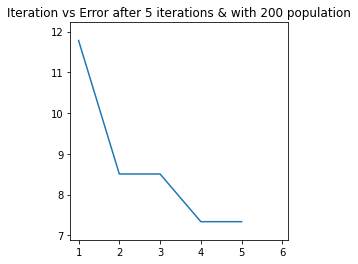

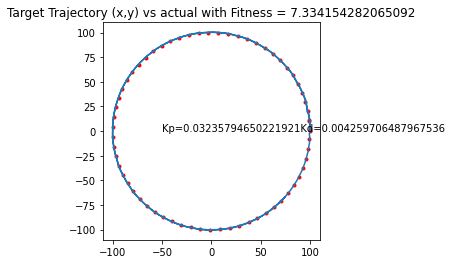

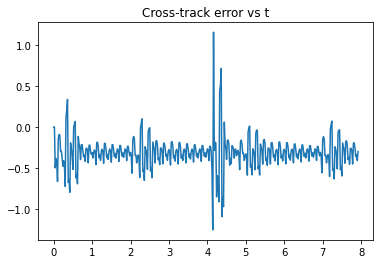

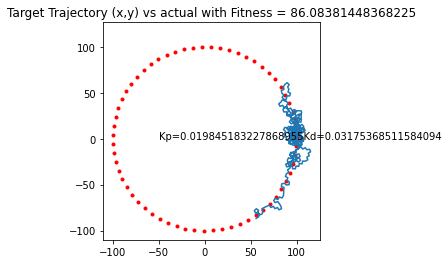

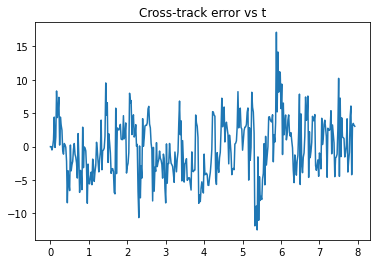

In [ ]:
TLBO(fit, iteration = 5, population = 200)